#Lab.05 / IBM3202 – Membrane Protein Modelling using PyRosetta

##Theoretical Aspects

As stated by Alford et al. 2020 [Biophys J 2020 118(8), 2042-2055], membrane proteins partner with the surrounding lipid environment to perform essential life processes. They constitute 30% of all proteins and are targets for over 60% of pharmaceuticals. However, experimental difficulties have limited our insights into their molecular mechanisms of function.

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/mpmodelling_01.jpg'/>
<figcaption>FIGURE 1. The challenge of solving the structure of membrane proteins. As shown in this graph, the number of membrane proteins solved before the extensive use of cryoEM was (and still is) significantly inferior to the number of soluble proteins.
<br>Bijelic A & Rompel A (2015) <i>Coord Chem Rev 299, 22-38.
</i></figcaption></center>
</figure>

Therefore, membrane protein modelling is ideal for determining the structure of these proteins and for developing new therapeutics. In this tutorial we will learn to model membrane proteins in PyRosetta and provide examples of the types of problems one can solve with this framework.

##Overview

In this tutorial, we will model different homologs with varying sequence identities of the membrane protein Glycophorin A, also known as GYPA. This is a pore-forming protein that, in the case of the human ortholog, has been broadly studied using different structural biology methods such as NMR and X-Ray crystallography.

This overview and tutorial include information from this [tutorial](http://www.meilerlab.org/jobs/downloadfile/name/May2018_rosetta_cm_presentation.pdf) by Nica Marlow and Georg Kuenze

**The Algorithm**

At a high-level, the algorithm consists of a long Monte Carlo trajectory starting from a randomly-chosen template. The MC trajectory employs the following moves:

* Fragment insertion in unaligned regions

* Replacement of a randomly-chosen segment with that from a different template structure

* Cartesian-space minimization using a smooth (differentiable) version of the Rosetta centroid energy function. Finally, this is followed by all-atom optimization.

See more at the [official docs](https://www.rosettacommons.org/docs/latest/application_documentation/structure_prediction/RosettaCM)

**Differences between Single and Multiple Template modeling**

Single Template Modeling:
- Single template as input
- Uses sequence and template derived
fragments
- Used when available templates have very
high identity (>60%)

Multiple Template Modeling:
- Multiple templates as input
- Combine sections of multiple threaded
models and sequence derived fragments
- Used when available templates have low
identity (30-50%)

**The protocol**

Rosetta comparative modelling (**RosettaCM**) performs a complex series of steps that are illustrated in the scheme below, but that can be summarize in three main steps:

1. Align target sequence to template sequences

2. Perform a partial-thread of the target sequence onto template structures

3. Combine pieces from different templates using RosettaCM hybridize

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/mpmodelling_02.jpg'/>
<figcaption>FIGURE 2. A simple scheme of the RosettaCM protocol
<br>Song Y et al (2013) <i>Structure 21(10), 1735-1742</i></figcaption></center>
</figure>

**Input Files for RosettaCM**

Bare minimum:

* Partial-threaded structures (✅)

* Mover definition and options (✅)

Specific to membrane proteins (not needed if modeling
soluble proteins):

* Membrane spanning regions (span file) (🙋)

* Membrane weight patches  (✅)

Optional files based on available information:

* Constraint information (eg. atom pair connectivity)

* Disulfide Connectivity

**For a deep dive into membrane protein modelling using Rosetta, we suggest to check the following articles:**
1. Alford RF, Leman JK et al., “An Integrated Framework Advancing Membrane Protein Modeling and Design,” PLOS Computational Biology. 2015;11(9).
2. Alford RF, Fleming PJ, Fleming KG, Gray JJ (2020) “Protein structure prediction and design in a biologically-realistic implicit membrane” BioRxiv
3. Koehler Leman J, Muller BK, Gray JJ (2017) “Expanding the toolkit for membrane protein modeling in Rosetta” Bioinformatics 33(5):754-756.
4. Koehler Leman J & Gray JJ (2015) “Computational modeling of membrane proteins” Proteins Structure, Function, and Bioinformatics 83(1):1-24.

#Part I – Exploring the sequences of GYPA orthologs

1. The sequences that we are going to be working with today  correspond to three ortologs of the Glycophorin A membrane protein. In our particular case we are going to model the following ortologs using PyRosetta:

  *   [Marmota flaviventris](https://www.ncbi.nlm.nih.gov/protein/XP_027782564.1?report=fasta&log$=seqview)

  *   [Gorilla gorilla](https://www.ncbi.nlm.nih.gov/protein/XP_007666620.2?report=fasta&log$=seqview)
  
  *   [Ornithorhynchus anatinus](https://www.uniprot.org/uniprot/O18798)

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/mpmodelling_03.png'/>
</figcaption></center>
</figure>

2. For the sake of time we are going to provide the already aligned and trimmed sequences in a Grishin format file (yet another alignment format), the partial-threaded structures required to run the modelling protocol and the fragment files:

  You will find these files inside its corresponding folder inside input_files. If you want to pursue the generation of these input files on your own, check **Appendix A**.



In [1]:
#Here we download the input files from Github
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/input_files/input_files_mp.zip
#This remove command is just in case you had some previous input files
!rm -rf input_files
#Here, we unzip the downloaded files
!unzip input_files_mp.zip

--2024-10-20 17:45:19--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/input_files/input_files_mp.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6407895 (6.1M) [application/zip]
Saving to: ‘input_files_mp.zip’

input_files_mp.zip  100%[===================>]   6.11M  37.0MB/s    in 0.2s    

2024-10-20 17:45:20 (37.0 MB/s) - ‘input_files_mp.zip’ saved [6407895/6407895]

Archive:  input_files_mp.zip
   creating: input_files/
   creating: input_files/grishin/
  inflating: __MACOSX/input_files/._grishin  
  inflating: input_files/.DS_Store   
  inflating: __MACOSX/input_files/._.DS_Store  
   creating: input_files/cleaned/
  inflating: __MACOSX/input_files/._cleaned  
   creating: input_files/fasta/
  inflating: __MACOSX/input_files/._fasta  
  in

#Part II – Determining the membrane spanning regions (span file) using OCTOPUS server

As we briefly noted at the begining of this tutorial (Overview), we need to give Rosetta a way of knowing to which residues a specific and implicit "membrane" potential needs to be applied. These instructions are generated based on the transmembrane (TM) prediction server [**OCTOPUS**](https://octopus.cbr.su.se)

1. In [**OCTOPUS**](https://octopus.cbr.su.se) you need to input the target protein sequence for the TM prediction. You can find these protein sequences inside the FASTA folder within the downloaded input files.

2. The, the topology files must be processed to convert them into span files as shown in the code cell below:

In [2]:
%%bash
cd /content/input_files/octopus
perl octopus2span.pl GYPA.topo.txt > GYPA.span
perl octopus2span.pl marmota.topo.txt > marmota.span
perl octopus2span.pl ornithorhynchus.topo.txt > ornithorhynchus.span
perl octopus2span.pl gorilla.topo.txt > gorilla.span

3. Once you obtained all the span files from **OCTOPUS**, remember to place them inside the following folder

```
/content/input_files/octopus #Sweet trick! You can open the folder clicking this path
```



# Part III – Setting Up PyRosetta and Executing the Membrane Protein Modelling protocols


1. We start by setting up PyRosetta in Google Colab, which will be installed in your Google Drive, for which you must provide access.

In [3]:
!pip install pyrosettacolabsetup
import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
import pyrosetta; pyrosetta.init()

Mounted at /content/google_drive

Note that USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE.
See https://github.com/RosettaCommons/rosetta/blob/main/LICENSE.md or email license@uw.edu for details.

Looking for compatible PyRosetta wheel file at google-drive/PyRosetta/colab.bin//wheels...
Found compatible wheel: /content/google_drive/MyDrive/PyRosetta/colab.bin/wheels//content/google_drive/MyDrive/PyRosetta/colab.bin/wheels/pyrosetta-2024.42+release.3366cf78a3-cp310-cp310-linux_x86_64.whl


┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENS

2. In the following cell code, we import the PyRosetta modules that we are going to use

In [4]:
#Here we import the PyRosetta modules that we are going to be using
%%time
import pandas as pd
from pyrosetta import *
from pyrosetta.rosetta.protocols.rosetta_scripts import *
from pyrosetta import (
    init, pose_from_sequence, pose_from_file, Pose, MoveMap, create_score_function, get_fa_scorefxn,
    MonteCarlo, TrialMover, SwitchResidueTypeSetMover, PyJobDistributor,
)


CPU times: user 420 ms, sys: 50.2 ms, total: 470 ms
Wall time: 514 ms


3. Next, we performing the Membrane Protein Modelling protocol. This is briefly described for the GYPA from _Gorilla_, whereas the modelling of GYPA for the other orthologs is just a modification of this protocol.

#### Gorilla 🦍

1. In the following cell code we give PyRosetta all the needed **Flags**. These flags are equivalent to command-line instructions in order to set the path for files and set the value of different (and numerous) options. We pass them into PyRosetta, thus initializing it


```
pyrosetta.init(flags)
```



In [5]:
#Flags are equivalent to command-line instructions in order to set the path for files and set the value of different options
flags = f"""
-no_fconfig
-in:file:fasta ./input_files/fasta/gorillaGYPA.fasta
-out:prefix GYPA_gorilla_
-out:path:all ./output_files
-in:file:spanfile ./input_files/octopus/gorilla.span
-membrane:no_interpolate_Mpair
-membrane:Menv_penalties
-rg_reweight .1
-relax:fast
-relax:minimize_bond_angles
-relax:minimize_bond_lengths
-relax:jump_move true
-default_max_cycles 2
-relax:min_type lbfgs_armijo_nonmonotone
-score:weights input_files/wts/stage3_rlx_membrane.wts
-use_bicubic_interpolation
-hybridize:stage1_probability 1.0
-sog_upper_bound 15
-chemical:exclude_patches LowerDNA  UpperDNA Cterm_amidation SpecialRotamer VirtualBB ShoveBB VirtualDNAPhosphate VirtualNTerm CTermConnect sc_orbitals pro_hydroxylated_case1 pro_hydroxylated_case2 ser_phosphorylated thr_phosphorylated  tyr_phosphorylated tyr_sulfated lys_dimethylated lys_monomethylated  lys_trimethylated lys_acetylated glu_carboxylated cys_acetylated tyr_diiodinated N_acetylated C_methylamidated MethylatedProteinCterm
-analytic_etable_evaluation true
-linmem_ig 10
-out:mute core.io.pose_from_sfr.PoseFromSFRBuilder core.scoring.MembranePotential core.chemical.GlobalResidueTypeSet basic.io.database core.scoring.MembraneTopology core.scoring.CartesianBondedEnergy core.conformation.Conformation protocols.jd2.parser.ScoreFunctionLoader core.optimization.AtomTreeMinimizer core.pack
"""
pyrosetta.init(flags)

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.MinSizeRel.python310.ubuntu 2024.42+release.3366cf78a3df04339d1982e94531b77b098ddb99 2024-10-11T08:24:04] retrieved from: http://www.pyrosetta.org
core.init: Rosetta version: PyRosetta4.MinSizeRel.python310.ubuntu r388 2024.42+release.3366cf78a3 3366cf78a3df04339d1982e94531b77b098ddb99 http://www.pyrosetta.org 202

2. One of the crucial concepts in PyRosetta are **poses**. They contain the information, sequence or structure, to which the protocol will be applied.

  With this in mind, here we create a **pose object** from a sequence, which in this case is the sequence of the GYPA from **_Gorilla_**. Also, we specify a **res_type** which corresponds to the **fullatom_standard**.

In [6]:
#Here we create a pose object from a sequence
#Also, we specify a res_type which corresponds to the fullatom_standard
%%time
pose = pose_from_sequence('DNGEWIQLVPRFSGPEITLIIFGVMAGIIGTILLISYSIRRL', 'fa_standard')

CPU times: user 953 ms, sys: 73.8 ms, total: 1.03 s
Wall time: 1.05 s


3. While there are multiple ways of creating a protocol in Rosetta, in our case we are going to create a protocol from a **XML object**.

**NOTE:** In the **MOVERS** tag we specify the **fragment files** and the **threaded_pdb**!!

In [7]:
#Creating a Rosetta protocol from a XML object
#Note that in the <MOVERS> we specify the fragment files and the threaded_pdb!!

%%time
xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
<ROSETTASCRIPTS>
    <TASKOPERATIONS>
    </TASKOPERATIONS>
    <RESIDUE_SELECTORS>
    </RESIDUE_SELECTORS>
    <SCOREFXNS>
      <ScoreFunction name="stage1" weights="input_files/wts/stage1_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="1"/>
      </ScoreFunction>
      <ScoreFunction name="stage2" weights="input_files/wts/stage2_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
      </ScoreFunction>
      <ScoreFunction name="fullatom" weights="input_files/wts/stage3_rlx_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
      </ScoreFunction>
      <ScoreFunction name="membrane" weights="membrane_highres_Menv_smooth" symmetric="0">
        <Reweight scoretype="cart_bonded" weight="0.5"/>
        <Reweight scoretype="pro_close" weight="0"/>
	 <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
	</ScoreFunction>
    </SCOREFXNS>
    <FILTERS>
    </FILTERS>
    <MOVERS>
        	 <Hybridize name="hybridize" stage1_scorefxn="stage1" stage2_scorefxn="stage2" fa_scorefxn="fullatom" batch="1" stage1_increase_cycles="0.5" stage2_increase_cycles="0.5" linmin_only="1" add_hetatm="0" hetatm_to_protein_cst_weight="0"  >
       			<Fragments three_mers="/content/input_files/frags/gorillaGYPA.9mers" nine_mers="/content/input_files/frags/gorillaGYPA.9mers" />
	          	<Template pdb="/content/input_files/threaded_pdbs/5eh6_A.gorilla.pdb" cst_file="AUTO" weight="1.000" />
	       </Hybridize>
    </MOVERS>
    <APPLY_TO_POSE>
    </APPLY_TO_POSE>
    <PROTOCOLS>
      Add mover="add_memb"
	    <Add mover="hybridize"/>
    </PROTOCOLS>
<OUTPUT scorefxn="membrane"/>
</ROSETTASCRIPTS>
    """).get_mover("ParsedProtocol")

protocols.rosetta_scripts.RosettaScriptsParser: Validating input script...
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: Generating XML Schema for rosetta_scripts...
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: ...done
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: Initializing schema validator...
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: ...done
protocols.rosetta_scripts.RosettaScriptsParser: ...done
protocols.rosetta_scripts.RosettaScriptsParser: Parsed script:
<ROSETTASCRIPTS>
	<TASKOPERATIONS/>
	<RESIDUE_SELECTORS/>
	<SCOREFXNS>
		<ScoreFunction name="stage1" symmetric="0" weights="input_files/wts/stage1_membrane.wts">
			<Reweight scoretype="atom_pair_constraint" weight="1"/>
		</ScoreFunction>
		<ScoreFunction name="stage2" symmetric="0" weights="input_files/wts/stage2_membrane.wts">
			<Reweight scoretype="atom_pair_constraint" weight="0.5"/>
		</ScoreFunction>
		<ScoreFunction name="fullatom" symmetric="0" weights="input_files/wts

4. Once our protocol is set up, in the following code cells:
  * We create a membrane score function
  * Then, we call the PyJobDistrubutor and pass three arguments
    * A name prefix to output our models as PDB files
    * The number of models to generate
    * The score function to employ
  * We pass our pose to the job distributor that we just created
  * Then, we create a Pandas dataframe to store the score results
  * Finally, we loop while the jobs are not completed

In [11]:
#Here we create a membrane score function
membrane = pyrosetta.create_score_function("membrane_highres_Menv_smooth")
#Here we create a job distributor object and specify the prefix, number of output models or poses and the scorefunction
jd = pyrosetta.toolbox.py_jobdistributor.PyJobDistributor(pdb_name="GYPA_gorilla_",nstruct=2,scorefxn=membrane)
#Here we pass our previously created pose to the Job Distributor
jd.native_pose = pose
#Here we create a panda dataframe in order to store our score results as we are going to see later
gdf = pd.DataFrame()
#Here we loop until all n jobs are completed
while not jd.job_complete:
    test_pose = pose.clone()
    xml.apply(test_pose)
    test_gdf = pd.DataFrame.from_records(dict(test_pose.scores), index=[jd.current_name])
    gdf = pd.concat([gdf, test_gdf])
    jd.output_decoy(test_pose)

Working on decoy: GYPA_gorilla__0.pdb
protocols.rosetta_scripts.ParsedProtocol: =======================BEGIN MOVER Hybridize - hybridize=======================
protocols.hybridization.HybridizeProtocol: FRAGMENTS small max length: 9
protocols.hybridization.HybridizeProtocol: FRAGMENTS big max length: 9
protocols.hybridization.HybridizeProtocol: Using initial template:    1 /content/input_files/threaded_pdbs/5eh6_A.gorilla.pdb
protocols.hybridization.HybridizeProtocol: Align domain with TMscore of    1.000
protocols.hybridization.HybridizeProtocol: PEITLIIFGVMAGIIGTILLISYSIRRL
protocols.hybridization.HybridizeProtocol: ::::::::::::::::::::::::::::
protocols.hybridization.HybridizeProtocol: PEITLIIFGVMAGIIGTILLISYSIRRL
core.fragment: compute strand/loop fractions for 42 residues...
protocols.hybridization.FoldTreeHybridize: Secondary structure from fragments: LLLLEEEEELLLLLLLEEEEEHHHHHHHHHHHHHHHHHHHHL
protocols.hybridization.FoldTreeHybridize: Steal chunks with rate = 0
protocols.hybridi

#### Ornitorrinchus 🥚

In [12]:
flags = f"""
-no_fconfig
-in:file:fasta ./input_files/fasta/ornithorhynchusGYPA.fasta
-out:prefix GYPA_ornithorhynchus_
-in:file:spanfile ./input_files/octopus/ornithorhynchus.span
-membrane:no_interpolate_Mpair
-membrane:Menv_penalties
-rg_reweight .1
-relax:fast
-relax:minimize_bond_angles
-relax:minimize_bond_lengths
-relax:jump_move true
-default_max_cycles 2
-relax:min_type lbfgs_armijo_nonmonotone
-score:weights input_files/wts/stage3_rlx_membrane.wts
-use_bicubic_interpolation
-hybridize:stage1_probability 1.0
-sog_upper_bound 15
-chemical:exclude_patches LowerDNA  UpperDNA Cterm_amidation SpecialRotamer VirtualBB ShoveBB VirtualDNAPhosphate VirtualNTerm CTermConnect sc_orbitals pro_hydroxylated_case1 pro_hydroxylated_case2 ser_phosphorylated thr_phosphorylated  tyr_phosphorylated tyr_sulfated lys_dimethylated lys_monomethylated  lys_trimethylated lys_acetylated glu_carboxylated cys_acetylated tyr_diiodinated N_acetylated C_methylamidated MethylatedProteinCterm
-analytic_etable_evaluation true
-linmem_ig 10
-out:mute core.io.pose_from_sfr.PoseFromSFRBuilder core.scoring.MembranePotential core.chemical.GlobalResidueTypeSet basic.io.database core.scoring.MembraneTopology core.scoring.CartesianBondedEnergy core.conformation.Conformation protocols.jd2.parser.ScoreFunctionLoader core.optimization.AtomTreeMinimizer core.pack
"""
pyrosetta.init(flags)

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.MinSizeRel.python310.ubuntu 2024.42+release.3366cf78a3df04339d1982e94531b77b098ddb99 2024-10-11T08:24:04] retrieved from: http://www.pyrosetta.org
core.init: Rosetta version: PyRosetta4.MinSizeRel.python310.ubuntu r388 2024.42+release.3366cf78a3 3366cf78a3df04339d1982e94531b77b098ddb99 http://www.pyrosetta.org 202

In [13]:
%%time
pose = pose_from_sequence('IDPEIEHIFTGPVAAVIIYAVVCGVIGTILFIALVIKVV', 'fa_standard')

CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 14.4 ms


In [14]:
%%time
xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
<ROSETTASCRIPTS>
    <TASKOPERATIONS>
    </TASKOPERATIONS>
    <RESIDUE_SELECTORS>
    </RESIDUE_SELECTORS>
    <SCOREFXNS>
      <ScoreFunction name="stage1" weights="input_files/wts/stage1_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="1"/>
      </ScoreFunction>
      <ScoreFunction name="stage2" weights="input_files/wts/stage2_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
      </ScoreFunction>
      <ScoreFunction name="fullatom" weights="input_files/wts/stage3_rlx_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
      </ScoreFunction>
      <ScoreFunction name="membrane" weights="membrane_highres_Menv_smooth" symmetric="0">
        <Reweight scoretype="cart_bonded" weight="0.5"/>
        <Reweight scoretype="pro_close" weight="0"/>
	 <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
	</ScoreFunction>
    </SCOREFXNS>
    <FILTERS>
    </FILTERS>
    <MOVERS>
          AddMembraneMover name="add_memb"
        	 <Hybridize name="hybridize" stage1_scorefxn="stage1" stage2_scorefxn="stage2" fa_scorefxn="fullatom" batch="1" stage1_increase_cycles="0.5" stage2_increase_cycles="0.5" linmin_only="1" add_hetatm="0" hetatm_to_protein_cst_weight="0"  >
       			<Fragments three_mers="/content/input_files/frags/ornithorhynchusGYPA.3mers" nine_mers="/content/input_files/frags/ornithorhynchusGYPA.9mers" />
	          	<Template pdb="/content/input_files/threaded_pdbs/5eh6_A.ornithorhynchus.pdb" cst_file="AUTO" weight="1.000" />
	       </Hybridize>
    </MOVERS>
    <APPLY_TO_POSE>
    </APPLY_TO_POSE>
    <PROTOCOLS>
      Add mover="add_memb"
	    <Add mover="hybridize"/>
    </PROTOCOLS>
<OUTPUT scorefxn="membrane"/>
</ROSETTASCRIPTS>
    """).get_mover("ParsedProtocol")

protocols.rosetta_scripts.RosettaScriptsParser: Validating input script...
protocols.rosetta_scripts.RosettaScriptsParser: ...done
protocols.rosetta_scripts.RosettaScriptsParser: Parsed script:
<ROSETTASCRIPTS>
	<TASKOPERATIONS/>
	<RESIDUE_SELECTORS/>
	<SCOREFXNS>
		<ScoreFunction name="stage1" symmetric="0" weights="input_files/wts/stage1_membrane.wts">
			<Reweight scoretype="atom_pair_constraint" weight="1"/>
		</ScoreFunction>
		<ScoreFunction name="stage2" symmetric="0" weights="input_files/wts/stage2_membrane.wts">
			<Reweight scoretype="atom_pair_constraint" weight="0.5"/>
		</ScoreFunction>
		<ScoreFunction name="fullatom" symmetric="0" weights="input_files/wts/stage3_rlx_membrane.wts">
			<Reweight scoretype="atom_pair_constraint" weight="0.5"/>
		</ScoreFunction>
		<ScoreFunction name="membrane" symmetric="0" weights="membrane_highres_Menv_smooth">
			<Reweight scoretype="cart_bonded" weight="0.5"/>
			<Reweight scoretype="pro_close" weight="0"/>
			<Reweight scoretype="atom

In [15]:
%%time
membrane = pyrosetta.create_score_function("membrane_highres_Menv_smooth")
jd = pyrosetta.toolbox.py_jobdistributor.PyJobDistributor(pdb_name="GYPA_ornitorrinchus",nstruct=2,scorefxn=membrane)
jd.native_pose = pose
odf = pd.DataFrame()
while not jd.job_complete:
    test_pose = pose.clone()
    xml.apply(test_pose)
    test_odf = pd.DataFrame.from_records(dict(test_pose.scores), index=[jd.current_name])
    odf = pd.concat([odf, test_odf])
    jd.output_decoy(test_pose)

Working on decoy: GYPA_ornitorrinchus_1.pdb
protocols.rosetta_scripts.ParsedProtocol: =======================BEGIN MOVER Hybridize - hybridize=======================
protocols.hybridization.HybridizeProtocol: Found 1 domains using template /content/input_files/threaded_pdbs/5eh6_A.ornithorhynchus.pdb
protocols.hybridization.HybridizeProtocol: domain 1: LOOP  begin  end  cut  skip_rate  extended
protocols.hybridization.HybridizeProtocol: LOOP start: 1  stop: 39  cut: 0  size: 39  skip rate: 0  extended?: False
protocols.hybridization.HybridizeProtocol:
protocols.hybridization.HybridizeProtocol:
protocols.hybridization.HybridizeProtocol: FRAGMENTS small max length: 3
protocols.hybridization.HybridizeProtocol: FRAGMENTS big max length: 9
protocols.hybridization.HybridizeProtocol: Using initial template:    1 /content/input_files/threaded_pdbs/5eh6_A.ornithorhynchus.pdb
protocols.hybridization.HybridizeProtocol: Align domain with TMscore of    1.000
protocols.hybridization.HybridizeProtoco

####Marmota 🦡

In [16]:
%%time
flags = f"""
-no_fconfig
-in:file:fasta ./input_files/fasta/marmotaGYPA.fasta
-out:prefix GYPA_marmota_
-out:path:all ./output_files
-in:file:spanfile ./input_files/octopus/marmota.span
-membrane:no_interpolate_Mpair
-membrane:Menv_penalties
-rg_reweight .1
-relax:fast
-relax:minimize_bond_angles
-relax:minimize_bond_lengths
-relax:jump_move true
-default_max_cycles 2
-relax:min_type lbfgs_armijo_nonmonotone
-score:weights input_files/wts/stage3_rlx_membrane.wts
-use_bicubic_interpolation
-hybridize:stage1_probability 1.0
-sog_upper_bound 15
-chemical:exclude_patches LowerDNA  UpperDNA Cterm_amidation SpecialRotamer VirtualBB ShoveBB VirtualDNAPhosphate VirtualNTerm CTermConnect sc_orbitals pro_hydroxylated_case1 pro_hydroxylated_case2 ser_phosphorylated thr_phosphorylated  tyr_phosphorylated tyr_sulfated lys_dimethylated lys_monomethylated  lys_trimethylated lys_acetylated glu_carboxylated cys_acetylated tyr_diiodinated N_acetylated C_methylamidated MethylatedProteinCterm
-analytic_etable_evaluation true
-linmem_ig 10
-out:mute core.io.pose_from_sfr.PoseFromSFRBuilder core.scoring.MembranePotential core.chemical.GlobalResidueTypeSet basic.io.database core.scoring.MembraneTopology core.scoring.CartesianBondedEnergy core.conformation.Conformation protocols.jd2.parser.ScoreFunctionLoader core.optimization.AtomTreeMinimizer core.pack
"""
pyrosetta.init(flags)

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.MinSizeRel.python310.ubuntu 2024.42+release.3366cf78a3df04339d1982e94531b77b098ddb99 2024-10-11T08:24:04] retrieved from: http://www.pyrosetta.org
core.init: Rosetta version: PyRosetta4.MinSizeRel.python310.ubuntu r388 2024.42+release.3366cf78a3 3366cf78a3df04339d1982e94531b77b098ddb99 http://www.pyrosetta.org 202

In [17]:
%%time
pose = pose_from_sequence('KQGRNQIIHPFSEPVIILIIFAVMFGIIGTILLISFCVRRL', 'fa_standard')

CPU times: user 9.1 ms, sys: 0 ns, total: 9.1 ms
Wall time: 9.41 ms


In [18]:
%%time
xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
<ROSETTASCRIPTS>
    <TASKOPERATIONS>
    </TASKOPERATIONS>
    <RESIDUE_SELECTORS>
    </RESIDUE_SELECTORS>
    <SCOREFXNS>
      <ScoreFunction name="stage1" weights="input_files/wts/stage1_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="1"/>
      </ScoreFunction>
      <ScoreFunction name="stage2" weights="input_files/wts/stage2_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
      </ScoreFunction>
      <ScoreFunction name="fullatom" weights="input_files/wts/stage3_rlx_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
      </ScoreFunction>
      <ScoreFunction name="membrane" weights="membrane_highres_Menv_smooth" symmetric="0">
        <Reweight scoretype="cart_bonded" weight="0.5"/>
        <Reweight scoretype="pro_close" weight="0"/>
	 <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
	</ScoreFunction>
    </SCOREFXNS>
    <FILTERS>
    </FILTERS>
    <MOVERS>
          AddMembraneMover name="add_memb"
        	 <Hybridize name="hybridize" stage1_scorefxn="stage1" stage2_scorefxn="stage2" fa_scorefxn="fullatom" batch="1" stage1_increase_cycles="0.5" stage2_increase_cycles="0.5" linmin_only="1" add_hetatm="0" hetatm_to_protein_cst_weight="0"  >
       			<Fragments three_mers="./input_files/frags/marmotaGYPA.3mers" nine_mers="./input_files/frags/marmotaGYPA.9mers" />
	          	<Template pdb="./input_files/threaded_pdbs/5eh6_A.marmota.pdb" cst_file="AUTO" weight="1.000" />
	       </Hybridize>
    </MOVERS>
    <APPLY_TO_POSE>
    </APPLY_TO_POSE>
    <PROTOCOLS>
      Add mover="add_memb"
	    <Add mover="hybridize"/>
    </PROTOCOLS>
<OUTPUT scorefxn="membrane"/>
</ROSETTASCRIPTS>
    """).get_mover("ParsedProtocol")

protocols.rosetta_scripts.RosettaScriptsParser: Validating input script...
protocols.rosetta_scripts.RosettaScriptsParser: ...done
protocols.rosetta_scripts.RosettaScriptsParser: Parsed script:
<ROSETTASCRIPTS>
	<TASKOPERATIONS/>
	<RESIDUE_SELECTORS/>
	<SCOREFXNS>
		<ScoreFunction name="stage1" symmetric="0" weights="input_files/wts/stage1_membrane.wts">
			<Reweight scoretype="atom_pair_constraint" weight="1"/>
		</ScoreFunction>
		<ScoreFunction name="stage2" symmetric="0" weights="input_files/wts/stage2_membrane.wts">
			<Reweight scoretype="atom_pair_constraint" weight="0.5"/>
		</ScoreFunction>
		<ScoreFunction name="fullatom" symmetric="0" weights="input_files/wts/stage3_rlx_membrane.wts">
			<Reweight scoretype="atom_pair_constraint" weight="0.5"/>
		</ScoreFunction>
		<ScoreFunction name="membrane" symmetric="0" weights="membrane_highres_Menv_smooth">
			<Reweight scoretype="cart_bonded" weight="0.5"/>
			<Reweight scoretype="pro_close" weight="0"/>
			<Reweight scoretype="atom

In [19]:
membrane = pyrosetta.create_score_function("membrane_highres_Menv_smooth")
jd = pyrosetta.toolbox.py_jobdistributor.PyJobDistributor(pdb_name="GYPA_marmota_",nstruct=2,scorefxn=membrane)
jd.native_pose = pose
mdf = pd.DataFrame()
while not jd.job_complete:
    test_pose = pose.clone()
    xml.apply(test_pose)
    test_mdf = pd.DataFrame.from_records(dict(test_pose.scores), index=[jd.current_name])
    mdf = pd.concat([mdf, test_mdf])
    jd.output_decoy(test_pose)

Working on decoy: GYPA_marmota__0.pdb
protocols.rosetta_scripts.ParsedProtocol: =======================BEGIN MOVER Hybridize - hybridize=======================
protocols.hybridization.HybridizeProtocol: Found 1 domains using template ./input_files/threaded_pdbs/5eh6_A.marmota.pdb
protocols.hybridization.HybridizeProtocol: domain 1: LOOP  begin  end  cut  skip_rate  extended
protocols.hybridization.HybridizeProtocol: LOOP start: 1  stop: 41  cut: 0  size: 41  skip rate: 0  extended?: False
protocols.hybridization.HybridizeProtocol:
protocols.hybridization.HybridizeProtocol:
protocols.hybridization.HybridizeProtocol: FRAGMENTS small max length: 3
protocols.hybridization.HybridizeProtocol: FRAGMENTS big max length: 9
protocols.hybridization.HybridizeProtocol: Using initial template:    1 ./input_files/threaded_pdbs/5eh6_A.marmota.pdb
protocols.hybridization.HybridizeProtocol: Align domain with TMscore of    1.000
protocols.hybridization.HybridizeProtocol: PVIILIIFAVMFGIIGTILLISFCVRRL
prot

####Human 🧑

In [20]:
%%time
flags = f"""
-no_fconfig
-in:file:fasta ./input_files/fasta/GYPA.fasta
-parser:protocol ./input_files/cm.xml
-out:prefix GYPA_
-out:path:all ./output_files
-in:file:spanfile ./input_files/octopus/GYPA.span
-membrane:no_interpolate_Mpair
-membrane:Menv_penalties
-rg_reweight .1
-relax:fast
-relax:minimize_bond_angles
-relax:minimize_bond_lengths
-relax:jump_move true
-default_max_cycles 2
-relax:min_type lbfgs_armijo_nonmonotone
-score:weights input_files/wts/stage3_rlx_membrane.wts
-use_bicubic_interpolation
-hybridize:stage1_probability 1.0
-sog_upper_bound 15
-chemical:exclude_patches LowerDNA  UpperDNA Cterm_amidation SpecialRotamer VirtualBB ShoveBB VirtualDNAPhosphate VirtualNTerm CTermConnect sc_orbitals pro_hydroxylated_case1 pro_hydroxylated_case2 ser_phosphorylated thr_phosphorylated  tyr_phosphorylated tyr_sulfated lys_dimethylated lys_monomethylated  lys_trimethylated lys_acetylated glu_carboxylated cys_acetylated tyr_diiodinated N_acetylated C_methylamidated MethylatedProteinCterm
-analytic_etable_evaluation true
-linmem_ig 10
-out:mute core.io.pose_from_sfr.PoseFromSFRBuilder core.scoring.MembranePotential core.chemical.GlobalResidueTypeSet basic.io.database core.scoring.MembraneTopology core.scoring.CartesianBondedEnergy core.conformation.Conformation protocols.jd2.parser.ScoreFunctionLoader core.optimization.AtomTreeMinimizer core.pack
"""
pyrosetta.init(flags)

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.MinSizeRel.python310.ubuntu 2024.42+release.3366cf78a3df04339d1982e94531b77b098ddb99 2024-10-11T08:24:04] retrieved from: http://www.pyrosetta.org
core.init: Rosetta version: PyRosetta4.MinSizeRel.python310.ubuntu r388 2024.42+release.3366cf78a3 3366cf78a3df04339d1982e94531b77b098ddb99 http://www.pyrosetta.org 202

In [21]:
%%time
pose = pose_from_sequence('ETGERVQLAHHFSEPEITLIIFGVMAGVIGTILLISYGIRRL', 'fa_standard')

CPU times: user 9.16 ms, sys: 989 µs, total: 10.1 ms
Wall time: 10 ms


In [22]:
%%time
xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
<ROSETTASCRIPTS>
    <TASKOPERATIONS>
    </TASKOPERATIONS>
    <RESIDUE_SELECTORS>
    </RESIDUE_SELECTORS>
    <SCOREFXNS>
      <ScoreFunction name="stage1" weights="input_files/wts/stage1_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="1"/>
      </ScoreFunction>
      <ScoreFunction name="stage2" weights="input_files/wts/stage2_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
      </ScoreFunction>
      <ScoreFunction name="fullatom" weights="input_files/wts/stage3_rlx_membrane.wts" symmetric="0">
        <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
      </ScoreFunction>
      <ScoreFunction name="membrane" weights="membrane_highres_Menv_smooth" symmetric="0">
        <Reweight scoretype="cart_bonded" weight="0.5"/>
        <Reweight scoretype="pro_close" weight="0"/>
	 <Reweight scoretype="atom_pair_constraint" weight="0.5"/>
	</ScoreFunction>
    </SCOREFXNS>
    <FILTERS>
    </FILTERS>
    <MOVERS>
          AddMembraneMover name="add_memb"
        	 <Hybridize name="hybridize" stage1_scorefxn="stage1" stage2_scorefxn="stage2" fa_scorefxn="fullatom" batch="1" stage1_increase_cycles="0.5" stage2_increase_cycles="0.5" linmin_only="1" add_hetatm="0" hetatm_to_protein_cst_weight="0"  >
       			<Fragments three_mers="./input_files/frags/GYPA.3mers" nine_mers="./input_files/frags/GYPA.9mers" />
	          	<Template pdb="/content/input_files/threaded_pdbs/5eh6_A.human.pdb" cst_file="AUTO" weight="1.000" />
	       </Hybridize>
    </MOVERS>
    <APPLY_TO_POSE>
    </APPLY_TO_POSE>
    <PROTOCOLS>
      Add mover="add_memb"
	    <Add mover="hybridize"/>
    </PROTOCOLS>
<OUTPUT scorefxn="membrane"/>
</ROSETTASCRIPTS>
    """).get_mover("ParsedProtocol")

protocols.rosetta_scripts.RosettaScriptsParser: Validating input script...
protocols.rosetta_scripts.RosettaScriptsParser: ...done
protocols.rosetta_scripts.RosettaScriptsParser: Parsed script:
<ROSETTASCRIPTS>
	<TASKOPERATIONS/>
	<RESIDUE_SELECTORS/>
	<SCOREFXNS>
		<ScoreFunction name="stage1" symmetric="0" weights="input_files/wts/stage1_membrane.wts">
			<Reweight scoretype="atom_pair_constraint" weight="1"/>
		</ScoreFunction>
		<ScoreFunction name="stage2" symmetric="0" weights="input_files/wts/stage2_membrane.wts">
			<Reweight scoretype="atom_pair_constraint" weight="0.5"/>
		</ScoreFunction>
		<ScoreFunction name="fullatom" symmetric="0" weights="input_files/wts/stage3_rlx_membrane.wts">
			<Reweight scoretype="atom_pair_constraint" weight="0.5"/>
		</ScoreFunction>
		<ScoreFunction name="membrane" symmetric="0" weights="membrane_highres_Menv_smooth">
			<Reweight scoretype="cart_bonded" weight="0.5"/>
			<Reweight scoretype="pro_close" weight="0"/>
			<Reweight scoretype="atom

In [23]:
%%time
membrane = pyrosetta.create_score_function("membrane_highres_Menv_smooth")
jd = pyrosetta.toolbox.py_jobdistributor.PyJobDistributor(pdb_name="GYPA_human_",nstruct=2,scorefxn=membrane)
jd.native_pose = pose
#Name of the score dataframe
hdf = pd.DataFrame()
while not jd.job_complete:
    test_pose = pose.clone()
    xml.apply(test_pose)
    test_hdf = pd.DataFrame.from_records(dict(test_pose.scores), index=[jd.current_name])
    hdf = pd.concat([hdf, test_hdf])
    jd.output_decoy(test_pose)

Working on decoy: GYPA_human__1.pdb
protocols.rosetta_scripts.ParsedProtocol: =======================BEGIN MOVER Hybridize - hybridize=======================
protocols.hybridization.HybridizeProtocol: Found 1 domains using template /content/input_files/threaded_pdbs/5eh6_A.human.pdb
protocols.hybridization.HybridizeProtocol: domain 1: LOOP  begin  end  cut  skip_rate  extended
protocols.hybridization.HybridizeProtocol: LOOP start: 1  stop: 42  cut: 0  size: 42  skip rate: 0  extended?: False
protocols.hybridization.HybridizeProtocol:
protocols.hybridization.HybridizeProtocol:
protocols.hybridization.HybridizeProtocol: FRAGMENTS small max length: 3
protocols.hybridization.HybridizeProtocol: FRAGMENTS big max length: 9
protocols.hybridization.HybridizeProtocol: Using initial template:    1 /content/input_files/threaded_pdbs/5eh6_A.human.pdb
protocols.hybridization.HybridizeProtocol: Align domain with TMscore of    1.000
protocols.hybridization.HybridizeProtocol: PEITLIIFGVMAGVIGTILLISYGI

#Part IV – Analyze and visualize the modelled structures

1. Now, we need to determine our best models by analyzing their score dataframes. For this, we are going to obtain the data frame for each of the models that we generated with PyRosetta.

  We can visually inspect these data frames just writing their name in a code chunk.

In [24]:
#Call here the name of the different dataframes that were created
hdf


,Menv_smooth,atom_pair_constraint,cart_bonded,dslf_ca_dih,dslf_cs_ang,dslf_ss_dih,dslf_ss_dst,fa_atr,fa_dun,fa_intra_rep,...,fa_rep,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,omega,p_aa_pp,rama,ref,total_score
GYPA_human__1.pdb,-2.602461,4.677751,167.787798,0.0,0.0,0.0,0.0,-185.079815,48.942319,117.095685,...,90.489134,-0.442582,0.0,0.000000,-34.828282,0.895635,1.832539,-18.474291,-4.61,-3.209094
GYPA_human__0.pdb,-5.413962,5.382300,168.358186,0.0,0.0,0.0,0.0,-151.427025,45.066502,120.515500,...,60.122577,-0.341836,0.0,-0.261213,-39.221145,-3.122443,-7.371308,-20.630833,-4.61,-15.326076


In [25]:
odf


,Menv_smooth,atom_pair_constraint,cart_bonded,dslf_ca_dih,dslf_cs_ang,dslf_ss_dih,dslf_ss_dst,fa_atr,fa_dun,fa_intra_rep,...,fa_rep,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,omega,p_aa_pp,rama,ref,total_score
GYPA_ornitorrinchus_1.pdb,6.801851,5.455776,172.821656,0.0,0.0,0.0,0.0,-179.652744,29.388224,128.965199,...,52.207441,0.000000,0.0,0.0,-44.985920,-1.803436,-8.130390,-17.206839,5.0,-37.664419
GYPA_ornitorrinchus_0.pdb,11.359693,5.327946,154.337543,0.0,0.0,0.0,0.0,-166.299082,27.638869,123.135727,...,55.907397,-0.069027,0.0,0.0,-43.846114,-3.701601,-8.635703,-22.432960,5.0,-34.373575


In [26]:
mdf


,Menv_smooth,atom_pair_constraint,cart_bonded,dslf_ca_dih,dslf_cs_ang,dslf_ss_dih,dslf_ss_dst,fa_atr,fa_dun,fa_intra_rep,...,fa_rep,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,omega,p_aa_pp,rama,ref,total_score
GYPA_marmota__0.pdb,-18.686129,4.961442,110.212905,0.0,0.0,0.0,0.0,-183.55478,57.813045,150.691747,...,46.933810,-0.528759,0.0,0.000000,-35.741563,-3.535251,-3.941944,-18.473909,-1.24,-68.240693
GYPA_marmota__1.pdb,-14.384180,5.214092,712.509674,0.0,0.0,0.0,0.0,-195.38371,60.815309,245.529592,...,124.967307,0.000000,0.0,-0.593745,-37.025284,1.406749,-2.927329,-12.514954,-1.24,266.560859


In [27]:
gdf

,Menv_smooth,atom_pair_constraint,cart_bonded,dslf_ca_dih,dslf_cs_ang,dslf_ss_dih,dslf_ss_dst,fa_atr,fa_dun,fa_intra_rep,...,fa_rep,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,omega,p_aa_pp,rama,ref,total_score
GYPA_gorilla__0.pdb,-9.721510,6.292492,167.746912,0.0,0.0,0.0,0.0,-166.504488,45.505765,128.476668,...,42.112057,-0.56426,0.0,0.0,-39.371535,-3.707682,-8.545411,-22.047972,-4.81,-35.436458
GYPA_gorilla__1.pdb,-3.875817,4.847885,165.079096,0.0,0.0,0.0,0.0,-174.246776,47.752706,133.345832,...,48.862424,0.00000,0.0,0.0,-39.315911,-3.443383,-1.472890,-25.490143,-4.81,-27.300132


2. As Rosetta uses an stochastic algorithm for comparative modelling, we are only interested in the low energy structures. Thus, we can sort our models by the column total_score as in the following cell code:

In [28]:
#hdf.sort_values('total_score')
gdf.sort_values('total_score')

,Menv_smooth,atom_pair_constraint,cart_bonded,dslf_ca_dih,dslf_cs_ang,dslf_ss_dih,dslf_ss_dst,fa_atr,fa_dun,fa_intra_rep,...,fa_rep,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,omega,p_aa_pp,rama,ref,total_score
GYPA_gorilla__0.pdb,-9.721510,6.292492,167.746912,0.0,0.0,0.0,0.0,-166.504488,45.505765,128.476668,...,42.112057,-0.56426,0.0,0.0,-39.371535,-3.707682,-8.545411,-22.047972,-4.81,-35.436458
GYPA_gorilla__1.pdb,-3.875817,4.847885,165.079096,0.0,0.0,0.0,0.0,-174.246776,47.752706,133.345832,...,48.862424,0.00000,0.0,0.0,-39.315911,-3.443383,-1.472890,-25.490143,-4.81,-27.300132


3. Having too many tables or tables with too much information would be challenging to analyze our results. For simplicity, we can make a plot with the **total_score** of each PDB for each species using **matplotlib**

<Axes: xlabel='total_score', ylabel='index'>

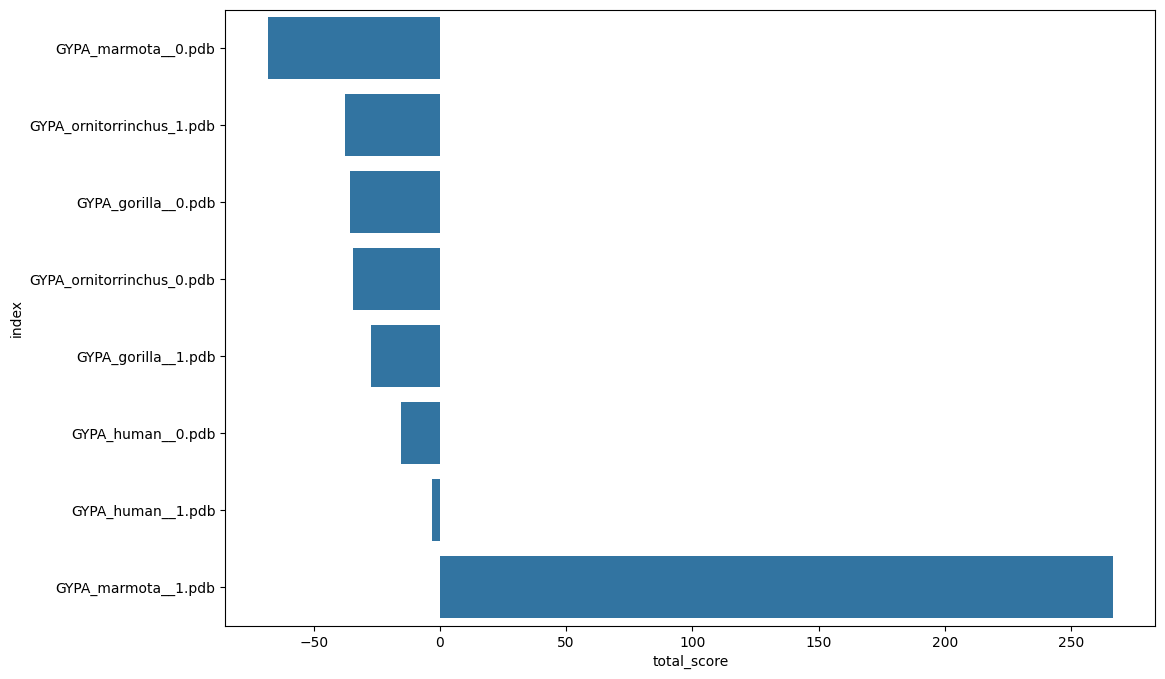

In [29]:
import matplotlib
import seaborn
frames = [hdf,odf,mdf,gdf]
results = pd.concat(frames)
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
seaborn.barplot(x="total_score", y="index", data=results.sort_values('total_score').reset_index())

4. Finally, we can take a look at our best models using **py3Dmol**

In [49]:
#!pip install py3Dmol
import py3Dmol
view=py3Dmol.view()
view.setBackgroundColor('white')
#Loading template
view.addModel(open('input_files/pdbs/5eh6.pdb', 'r').read(),'pdb')
view.addModel(open('GYPA_gorilla__0.pdb', 'r').read(),'pdb')
view.setStyle({'chain':'A'},{'cartoon': {'color':'spectrum'}})
view.zoomTo()
view.show()
#The following is a small trick to be able to manipulate (rotate, zoom) your
#representation in Google Colab and, once you are happy with the visualization,
#press Enter to print out as an onscreen png image file that you can download
#input()
#view.png()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**📚HOMEWORK:** As a challenge, using what you have learned in the previous tutorials to superimpose structures and determine their similarity using RMSD, take your best structures and compare them to answer the following question: **Is the TM region different between orthologs?**

5. To finalize, you can download your output files as indicated in the code cell below

In [ ]:
#download your output
%%bash
zip -r example.zip ./outs
mkdir outs
cp *.pdb ./outs/

**This is the end of the fifth tutorial. Good Science!**

#Appendix A

## Generating the input files using the standalone command-line version of Rosetta

First, you need to get a Rosetta license [HERE](https://els2.comotion.uw.edu/product/rosetta), as you did for PyRosetta

### Download and extract Rosetta in Google Colab (ETA ~15min)

In [ ]:
!wget --user=Academic_User --password=Xry3x4 https://www.rosettacommons.org/downloads/academic/3.12/rosetta_bin_linux_3.12_bundle.tgz
!tar xvf /content/rosetta_bin_linux_3.12_bundle.tgz

In [ ]:
!unzip input_files.zip

### Grishin File Generation

The Grishin alignment file format is documented [here](https://www.rosettacommons.org/docs/latest/rosetta_basics/file_types/Grishan-format-alignment). The following is an example of its structure
```
## target_name template_name.pdb
#
scores from program: 0
0 HERE_GOES_YOUR_TARGET_SEQUENCE_ALIGNMENT_IN_ONE_LINE
0 HERE_GOES_YOUR_TEMPLATE_SEQUENCE_ALIGNMENT_IN_ONE_LINE
```
This is one of the real Grishin files used in this tutorial
```
## gorillaGYPA 5eh6_A.pdb
#
scores from program: 0
0 DNGEWIQLVPRFSGPEITLIIFGVMAGIIGTILLISYSIRRL
0 --------------PEITLIIFGVIAGVIGTILLISYGIRRL
```



In [ ]:
#Modify and run this cell to create grishin from clustal alignment
%%bash
echo \
"""\
## gorillaGYPA 5eh6_A.pdb
#
scores from program: 0
0 DNGEWIQLVPRFSGPEITLIIFGVMAGIIGTILLISYSIRRL
0 --------------PEITLIIFGVIAGVIGTILLISYGIRRL
""" > /content/input_files/grishin/5eh6_on_gorillaGYPA.grishin

echo \
"""\
## GYPA 5eh6_A.pdb
#
scores from program: 0
0 ETGERVQLAHHFSEPEITLIIFGVMAGVIGTILLISYGIRRL
0 --------------PEITLIIFGVIAGVIGTILLISYGIRRL
""" > /content/input_files/grishin/5eh6_on_humanGYPA.grishin

echo \
"""\
## marmotaGYPA 5eh6_A.pdb
#
scores from program: 0
0 -KQGRNQIIHPFSEPVIILIIFAVMFGIIGTILLISFCVRRL
0 --------------PEITLIIFGVIAGVIGTILLISYGIRRL
""" > /content/input_files/grishin/5eh6_on_marmotaGYPA.grishin


echo \
"""\
## OrnithorhynchusGYPA 5eh6_A.pdb
#
scores from program: 0
0 ---IDPEIEHIFTGPVAAVIIYAVVCGVIGTILFIALVIKVV
0 --------------PEITLIIFGVIAGVIGTILLISYGIRRL
""" > /content/input_files/grishin/5eh6_on_ornithorhynchusGYPA.grishin

### Partial Threading

In [ ]:
import urllib.request
urllib.request.urlretrieve('http://files.rcsb.org/download/5eh6.pdb', '/content/input_files/pdbs/5eh6.pdb')

In [ ]:
%%bash
cd /content/input_files/pdbs
/content/rosetta_bin_linux_2020.08.61146_bundle/tools/protein_tools/scripts/clean_pdb.py 5eh6.pdb A
mv 5eh6_A.* ../cleaned

In [ ]:
!/content/rosetta_bin_linux_2020.08.61146_bundle/main/source/bin/partial_thread.static.linuxgccrelease -in:file:fasta ./fasta/GYPA.fasta -in:file:alignment ./grishin/5eh6.grishin -in:file:template_pdb ./cleaned/5eh6_A.pdb
!mv 5eh6_A.pdb.pdb 5eh6_A.human.pdb
!/content/rosetta_bin_linux_2020.08.61146_bundle/main/source/bin/partial_thread.static.linuxgccrelease -in:file:fasta ./fasta/ornithorhynchusGYPA.fasta -in:file:alignment ./grishin/5eh6_on_ornithorhynchusGYPA.grishin -in:file:template_pdb ./cleaned/5eh6_A.pdb
!mv 5eh6_A.pdb.pdb 5eh6_A.ornithorhynchus.pdb
!/content/rosetta_bin_linux_2020.08.61146_bundle/main/source/bin/partial_thread.static.linuxgccrelease -in:file:fasta ./fasta/marmotaGYPA.fasta -in:file:alignment ./grishin/5eh6_on_marmotaGYPA.grishin -in:file:template_pdb ./cleaned/5eh6_A.pdb
!mv 5eh6_A.pdb.pdb 5eh6_A.gorilla.pdb
!/content/rosetta_bin_linux_2020.08.61146_bundle/main/source/bin/partial_thread.static.linuxgccrelease -in:file:fasta ./fasta/gorillaGYPA.fasta -in:file:alignment ./grishin/5eh6_on_gorillaGYPA.grishin -in:file:template_pdb ./cleaned/5eh6_A.pdb
!mv 5eh6_A.pdb.pdb 5eh6_A.marmota.pdb
!mv 5eh6_A.*pdb ./input_files/threaded_pdbs/

### Getting the fragments from oldRobetta server


As stated in the Rosetta documentation fragments are:


> (...) used in the assembly of proteins whether for structure prediction or design, to cut down on the size of the protein-folding search space. They are a core part of the Rosetta design.

For the purpose of this tutorial, we skipped this part. However, in the following figure you can see a screenshot of the [Robetta-server](http://old.robetta.org/fragmentsubmit.jsp) where you can obtain the fragments. For this, you have to register and submit a FASTA sequence of your target proteins. Do keep in mind that the length of your target will impact in the time needed for the fragment picking process.

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/mpmodelling_04.png'/>
</figcaption></center>
</figure>

When your job is finished you will get an email with the corresponding fragments. You have to download them and place them inside the frags folder and make sure that their filename matches the one in XML RosettaScripts cell